### Stanford Paper on LSTM Neural Networks for stock prices volatility prediction

http://cs230.stanford.edu/projects_fall_2019/reports/26254244.pdf

### Tutorial for building an LSTM neural network for time-series prediction

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

### Importing the required libraries

In [577]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers

# Datetime

import datetime

# Scikit-Learn

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# GARCH model

import pyflux as pf

# Keras

from keras.models import Model
from keras.layers import *
from keras.utils.vis_utils import plot_model

# Tensorflow

import tensorflow as tf

### Reading the csv file with the financial data

In [578]:
df = pd.read_csv(r'input/financial_data.csv')

print (df.head())
print (df.shape)

   19900611  19900612  19900613  19900614  19900615  19900618  19900619  \
0    358.71    361.63    366.25    364.90    362.90    362.91    356.88   
1    361.63    366.25    364.90    362.90    362.91    356.88    358.47   
2    361.63    367.27    367.09    364.90    363.14    362.91    358.90   
3    357.70    361.15    364.51    361.64    360.71    356.88    356.18   
4      0.00      0.00      0.00      0.00      0.00      0.00      0.00   

   19900620  19900621  19900622    ...     20200528  20200529  20200601  \
0    358.47    359.10    360.47    ...      3046.61   3025.17   3038.78   
1    359.10    360.47    355.43    ...      3029.73   3044.31   3055.73   
2    359.91    360.88    363.20    ...      3068.67   3049.17   3062.18   
3    357.00    357.63    355.31    ...      3023.40   2998.61   3031.54   
4      0.00      0.00      0.00    ...         0.00      0.00      0.00   

   20200602  20200603  20200604  20200605  20200608  20200609  20200610  
0   3064.78   3098.90   

As we see here, we have 254 columns, corresponding to the 254 business days for which we have financial data and 10 columns, which are the 10 financial indicators we have.

# Data Cleaning

### Transposing the dataframe 

As we are working with time series data, we should have the dates as one column and will thus use transpose() for this.

In [579]:
df = df.transpose()

print(df.head())
print(df.shape)

               0       1       2       3    4    5    6    7    8    9
19900611  358.71  361.63  361.63  357.70  0.0  0.0  0.0  0.0  0.0  0.0
19900612  361.63  366.25  367.27  361.15  0.0  0.0  0.0  0.0  0.0  0.0
19900613  366.25  364.90  367.09  364.51  0.0  0.0  0.0  0.0  0.0  0.0
19900614  364.90  362.90  364.90  361.64  0.0  0.0  0.0  0.0  0.0  0.0
19900615  362.90  362.91  363.14  360.71  0.0  0.0  0.0  0.0  0.0  0.0
(7559, 10)


### Reset the index of the dataframe

In [580]:
df = df.reset_index()

print(df.head())

      index       0       1       2       3    4    5    6    7    8    9
0  19900611  358.71  361.63  361.63  357.70  0.0  0.0  0.0  0.0  0.0  0.0
1  19900612  361.63  366.25  367.27  361.15  0.0  0.0  0.0  0.0  0.0  0.0
2  19900613  366.25  364.90  367.09  364.51  0.0  0.0  0.0  0.0  0.0  0.0
3  19900614  364.90  362.90  364.90  361.64  0.0  0.0  0.0  0.0  0.0  0.0
4  19900615  362.90  362.91  363.14  360.71  0.0  0.0  0.0  0.0  0.0  0.0


### Renaming the columns with the financial indicators name

In [581]:
df = df.rename(columns={
    
    df.columns[0]: 'Date',
    df.columns[1]:'Open',
    df.columns[2]: 'Close',
    df.columns[3]:'High',
    df.columns[4]:'Low',
    df.columns[5]: 'Volume',
    df.columns[6]: 'RSI14',
    df.columns[7]:'SMA14',
    df.columns[8]: 'EMA14',
    df.columns[9]:'MACD_sl',
    df.columns[10]:'MACD_h'

})

print (df.head())

       Date    Open   Close    High     Low  Volume  RSI14  SMA14  EMA14  \
0  19900611  358.71  361.63  361.63  357.70     0.0    0.0    0.0    0.0   
1  19900612  361.63  366.25  367.27  361.15     0.0    0.0    0.0    0.0   
2  19900613  366.25  364.90  367.09  364.51     0.0    0.0    0.0    0.0   
3  19900614  364.90  362.90  364.90  361.64     0.0    0.0    0.0    0.0   
4  19900615  362.90  362.91  363.14  360.71     0.0    0.0    0.0    0.0   

   MACD_sl  MACD_h  
0      0.0     0.0  
1      0.0     0.0  
2      0.0     0.0  
3      0.0     0.0  
4      0.0     0.0  


### Converting the Date column into a Date

In [582]:
df['Date'] =  pd.to_datetime(df['Date'], format='%Y%m%d')

### Setting the Date column as the index

In [583]:
df.set_index('Date', inplace=True)

print(df.head())

              Open   Close    High     Low  Volume  RSI14  SMA14  EMA14  \
Date                                                                      
1990-06-11  358.71  361.63  361.63  357.70     0.0    0.0    0.0    0.0   
1990-06-12  361.63  366.25  367.27  361.15     0.0    0.0    0.0    0.0   
1990-06-13  366.25  364.90  367.09  364.51     0.0    0.0    0.0    0.0   
1990-06-14  364.90  362.90  364.90  361.64     0.0    0.0    0.0    0.0   
1990-06-15  362.90  362.91  363.14  360.71     0.0    0.0    0.0    0.0   

            MACD_sl  MACD_h  
Date                         
1990-06-11      0.0     0.0  
1990-06-12      0.0     0.0  
1990-06-13      0.0     0.0  
1990-06-14      0.0     0.0  
1990-06-15      0.0     0.0  


### Adding volume from Yahoo Finance API

In [584]:
start_date = '1990-06-11'
end_date = '2020-06-10'

In [585]:
panel_data = data.DataReader('^GSPC', 'yahoo', start_date, end_date)

In [586]:
print (panel_data.head())

print( panel_data.shape)

                  High         Low        Open       Close     Volume  \
Date                                                                    
1990-06-11  361.630005  357.700012  358.709991  361.630005  119550000   
1990-06-12  367.269989  361.149994  361.630005  366.250000  157100000   
1990-06-13  367.089996  364.510010  366.250000  364.899994  158910000   
1990-06-14  364.899994  361.640015  364.899994  362.899994  135770000   
1990-06-15  363.140015  360.709991  362.890015  362.910004  205130000   

             Adj Close  
Date                    
1990-06-11  361.630005  
1990-06-12  366.250000  
1990-06-13  364.899994  
1990-06-14  362.899994  
1990-06-15  362.910004  
(7559, 6)


In [587]:
df['Volume'] =  panel_data['Volume']

### Function to print out the data type of each column

In [588]:
def list_columns_to_dropna(df, column_list):
    
    for column in column_list:
        
        df = df[df[column].notna()]
        
    return df

In [589]:
column_list = ['Open','Close']

df = list_columns_to_dropna(df, column_list)

print (df.head())
print (df.shape)

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
1990-06-11  358.71  361.63  361.63  357.70  119550000    0.0    0.0    0.0   
1990-06-12  361.63  366.25  367.27  361.15  157100000    0.0    0.0    0.0   
1990-06-13  366.25  364.90  367.09  364.51  158910000    0.0    0.0    0.0   
1990-06-14  364.90  362.90  364.90  361.64  135770000    0.0    0.0    0.0   
1990-06-15  362.90  362.91  363.14  360.71  205130000    0.0    0.0    0.0   

            MACD_sl  MACD_h  
Date                         
1990-06-11      0.0     0.0  
1990-06-12      0.0     0.0  
1990-06-13      0.0     0.0  
1990-06-14      0.0     0.0  
1990-06-15      0.0     0.0  
(7559, 10)


In [590]:
def print_data_type_of_dataframe_columns(df):
    
    dataTypeSeries = df.dtypes
 
    print('Data type of each column of Dataframe :')
    print(dataTypeSeries)

# Feature Engineering

## Logarithmic Features

### Log Returns

In [591]:
df['Log_Returns'] = np.log(df.Close) - np.log(df.Close.shift(1))

print(df.head())
print(df.tail())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
1990-06-11  358.71  361.63  361.63  357.70  119550000    0.0    0.0    0.0   
1990-06-12  361.63  366.25  367.27  361.15  157100000    0.0    0.0    0.0   
1990-06-13  366.25  364.90  367.09  364.51  158910000    0.0    0.0    0.0   
1990-06-14  364.90  362.90  364.90  361.64  135770000    0.0    0.0    0.0   
1990-06-15  362.90  362.91  363.14  360.71  205130000    0.0    0.0    0.0   

            MACD_sl  MACD_h  Log_Returns  
Date                                      
1990-06-11      0.0     0.0          NaN  
1990-06-12      0.0     0.0     0.012695  
1990-06-13      0.0     0.0    -0.003693  
1990-06-14      0.0     0.0    -0.005496  
1990-06-15      0.0     0.0     0.000028  
               Open    Close     High      Low      Volume  RSI14    SMA14  \
Date                                                                      

### Log Trading Range

In [592]:
df['Log_Trading_Range'] = np.log(df.High) - np.log(df.Low)

print(df.head())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
1990-06-11  358.71  361.63  361.63  357.70  119550000    0.0    0.0    0.0   
1990-06-12  361.63  366.25  367.27  361.15  157100000    0.0    0.0    0.0   
1990-06-13  366.25  364.90  367.09  364.51  158910000    0.0    0.0    0.0   
1990-06-14  364.90  362.90  364.90  361.64  135770000    0.0    0.0    0.0   
1990-06-15  362.90  362.91  363.14  360.71  205130000    0.0    0.0    0.0   

            MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  
Date                                                         
1990-06-11      0.0     0.0          NaN           0.010927  
1990-06-12      0.0     0.0     0.012695           0.016804  
1990-06-13      0.0     0.0    -0.003693           0.007053  
1990-06-14      0.0     0.0    -0.005496           0.008974  
1990-06-15      0.0     0.0     0.000028           0.006714  


### Log Volume Change

In [593]:
df['Log_Volume_Change'] = np.log(df.Volume) - np.log(df.Volume.shift(1))

print(df.head())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
1990-06-11  358.71  361.63  361.63  357.70  119550000    0.0    0.0    0.0   
1990-06-12  361.63  366.25  367.27  361.15  157100000    0.0    0.0    0.0   
1990-06-13  366.25  364.90  367.09  364.51  158910000    0.0    0.0    0.0   
1990-06-14  364.90  362.90  364.90  361.64  135770000    0.0    0.0    0.0   
1990-06-15  362.90  362.91  363.14  360.71  205130000    0.0    0.0    0.0   

            MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  Log_Volume_Change  
Date                                                                            
1990-06-11      0.0     0.0          NaN           0.010927                NaN  
1990-06-12      0.0     0.0     0.012695           0.016804           0.273148  
1990-06-13      0.0     0.0    -0.003693           0.007053           0.011455  
1990-06-14      0.0     0.0    -0.005496        

## Volatility

### Previous 10-day Volatility

In [594]:
df['Previous_10_Day_Volatility'] = df['Log_Returns'].rolling(window = 10).std()

print(df.tail())

               Open    Close     High      Low      Volume  RSI14    SMA14  \
Date                                                                         
2020-06-04  3111.56  3112.35  3128.91  3090.41  6428130000  82.33  3006.42   
2020-06-05  3163.84  3193.93  3211.72  3163.84  8617590000  84.97  3030.00   
2020-06-08  3199.92  3232.39  3233.13  3196.00  8437380000  83.12  3049.90   
2020-06-09  3213.32  3207.18  3222.71  3193.11  6382620000  84.27  3070.20   
2020-06-10  3213.42  3190.14  3223.27  3181.49  6570840000  78.52  3085.81   

              EMA14  MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  \
Date                                                                   
2020-06-04  3019.03    58.68   12.44    -0.003374           0.012381   
2020-06-05  3042.35    62.71   16.10     0.025874           0.015020   
2020-06-08  3067.69    67.57   19.43     0.011970           0.011551   
2020-06-09  3086.29    72.14   18.28    -0.007830           0.009227   
2020-06-10  3100.14  

### Previous 30-day Volatility

In [595]:
df['Previous_30_Day_Volatility'] = df['Log_Returns'].rolling(window = 30).std()

print(df.head())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
1990-06-11  358.71  361.63  361.63  357.70  119550000    0.0    0.0    0.0   
1990-06-12  361.63  366.25  367.27  361.15  157100000    0.0    0.0    0.0   
1990-06-13  366.25  364.90  367.09  364.51  158910000    0.0    0.0    0.0   
1990-06-14  364.90  362.90  364.90  361.64  135770000    0.0    0.0    0.0   
1990-06-15  362.90  362.91  363.14  360.71  205130000    0.0    0.0    0.0   

            MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  \
Date                                                          
1990-06-11      0.0     0.0          NaN           0.010927   
1990-06-12      0.0     0.0     0.012695           0.016804   
1990-06-13      0.0     0.0    -0.003693           0.007053   
1990-06-14      0.0     0.0    -0.005496           0.008974   
1990-06-15      0.0     0.0     0.000028           0.006714   

           

### Next 10-days volatility

In [596]:
df['Next_10_Days_Volatility'] = df['Log_Returns'].iloc[::-1].rolling(window = 10).std().iloc[::-1]

print(df.head())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
1990-06-11  358.71  361.63  361.63  357.70  119550000    0.0    0.0    0.0   
1990-06-12  361.63  366.25  367.27  361.15  157100000    0.0    0.0    0.0   
1990-06-13  366.25  364.90  367.09  364.51  158910000    0.0    0.0    0.0   
1990-06-14  364.90  362.90  364.90  361.64  135770000    0.0    0.0    0.0   
1990-06-15  362.90  362.91  363.14  360.71  205130000    0.0    0.0    0.0   

            MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  \
Date                                                          
1990-06-11      0.0     0.0          NaN           0.010927   
1990-06-12      0.0     0.0     0.012695           0.016804   
1990-06-13      0.0     0.0    -0.003693           0.007053   
1990-06-14      0.0     0.0    -0.005496           0.008974   
1990-06-15      0.0     0.0     0.000028           0.006714   

           

In [597]:
df.dropna(inplace = True)

In [598]:
df.to_csv(r'output/output.csv')

## GARCH 

In [599]:
## Garch predictions for the entire dataset of SPX

### Building a new dataframe for splitting the dataframe in test and training data

In [600]:
X = df[df.first_valid_index():df.last_valid_index()- datetime.timedelta(1500)]

print (X.tail())

               Open    Close     High      Low      Volume  RSI14    SMA14  \
Date                                                                         
2016-04-13  2065.92  2082.42  2083.18  2065.92  4191830000  63.32  2055.58   
2016-04-14  2082.89  2082.78  2087.84  2078.13  3765870000  63.68  2058.92   
2016-04-15  2083.10  2080.73  2083.22  2076.31  3701450000  62.69  2062.04   
2016-04-18  2078.83  2094.34  2094.66  2073.65  3316880000  61.72  2064.85   
2016-04-19  2096.05  2100.80  2104.05  2091.68  3896830000  61.15  2067.48   

              EMA14  MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  \
Date                                                                   
2016-04-13  2052.77    21.99   -2.44     0.009990           0.008320   
2016-04-14  2056.77    21.65   -1.35     0.000173           0.004662   
2016-04-15  2059.96    21.42   -0.92    -0.000985           0.003322   
2016-04-18  2064.55    21.44    0.07     0.006520           0.010081   
2016-04-19  2069.38  

### Building a GARCH model using PyFlux

In [601]:
GARCH_model = pf.GARCH(X, target = 'Log_Returns', p=1, q=1)

x = GARCH_model.fit()

x.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: Log_Returns                         Method: MLE                                       
Start Date: 1990-07-25 00:00:00                         Log Likelihood: 21134.2564                        
End Date: 2016-04-19 00:00:00                           AIC: -42260.5128                                  
Number of observations: 6485                            BIC: -42233.4038                                  
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0                                                              
q(1)                                 

### Making rolling predictions using the GARCH Model

In [602]:
GARCH_rolling_predictions = GARCH_model.predict_is(h = len(X) - 50, fit_once = True)

print(GARCH_rolling_predictions.head())

KeyboardInterrupt: 

### Making forward-looking predictions using the GARCH Model

In [ ]:
GARCH_forward_looking_predictions = GARCH_model.predict(h=1500)

print(GARCH_forward_looking_predictions.head())

### Renaming one of the columns of the GARCH Model Dataframe

In [ ]:
GARCH_rolling_predictions.rename(columns={'Series':'GARCH_rolling_predictions'}, inplace =True)

GARCH_forward_looking_predictions.rename(columns={'Log_Returns':'GARCH_forward_looking_predictions'}, inplace =True)

### Adding the new feature to the current dataframe

In [ ]:
df = pd.concat([df, GARCH_rolling_predictions], axis=1)
df = pd.concat([df, GARCH_forward_looking_predictions], axis=1)

### Replacing Nan values with 0s for the GARCH Predictions columns

Rational for this from Keras's creator:

https://stackoverflow.com/questions/52570199/multivariate-lstm-with-missing-values

In [ ]:
df['GARCH_forward_looking_predictions'] =  df['GARCH_forward_looking_predictions'].fillna(0)
df['GARCH_rolling_predictions'] =  df['GARCH_rolling_predictions'].fillna(0)

### Checking the results of our transformations

In [ ]:
print (df.tail())

In [ ]:
# Notes

In [ ]:
# Better to predict VIX prices than realized volatility of SPX

In [ ]:
#Use it to predict VIX

Look at relationship of (5, 10, 30) realized volatility of SPX versus VIX prices (Plot)

Calculate in Excel

### Building a new dataframe for splitting the dataframe in test and training data

### Using dropna on several columns

In [ ]:
def list_columns_to_dropna(df, column_list):
    
    for column in column_list:
        
        df = df[df[column].notna()]
        
    return df

In [ ]:
column_list = ['Open', 'Log_Returns','Previous_10_Day_Volatility','Next_10_Days_Volatility','Previous_30_Day_Volatility']

df = list_columns_to_dropna(df, column_list)

print (df.head())
print (df.shape)

### Exporting the final dataframe to csv

In [ ]:
df.to_csv(r'output/output.csv')

# Exploratory Data Analysis (EDA)

### Plotting out the S&P 500 Prices from 1990 to 2020

In [ ]:
df['Close'].plot(label = 'S&P 500', figsize =(16,8), title = 'S&P 500 Stock Prices from 1990 to 2020')
plt.show()

### Plotting out the 10-days forward looking volatility of  S&P 500 Prices from 1990 to 2020

In [ ]:
df['Next_10_Days_Volatility'].plot(label = 'S&P 500', figsize =(16,8), title = '10-days forward looking volatility of  S&P 500 Prices from 1990 to 2020')
plt.show()

# Feature Selection

### Pearson Correlation Matrix

In [ ]:
def build_pearson_correlation_matrix_of_dataframe(size_x,size_y,dataframe,correlation_target,correlation_minimum_criteria):

    # Using Pearson Correlation

    plt.figure(figsize=(size_x,size_y))
    cor = dataframe.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.savefig('Images/pearson_correlation_matrix.png', bbox_inches='tight')
    plt.show()

    # Correlation with output variable

    target = abs(cor[correlation_target])

    #Selecting and printing highly correlated features

    relevant_features = target[target>correlation_minimum_criteria]
    print(relevant_features)

In [ ]:
build_pearson_correlation_matrix_of_dataframe(20,20,df,"Next_10_Days_Volatility",0.2)

# Data Preparation

### Splitting the data into train and test sets

In [627]:
X = np.array(df.drop(["Next_10_Days_Volatility",'Low','High','Close','Open','Volume','MACD_h','MACD_sl','RSI14','SMA14','EMA14'], axis=1).values)
y = np.array(df["Next_10_Days_Volatility"].values).reshape(-1, 1) 

test_size = 1500

X_train = X[test_size:,]
X_test = X[:test_size,]
y_train = y[test_size:]
y_test = y[:test_size]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6020, 5) (6020, 1)
(1500, 5) (1500, 1)


### Defining a function to get lagged versions of the features

This function increases the number of features of the dataset by "lagging" every feature.

In [628]:
def get_lagged(x, y, t, s):
    
    lagged = []
    
    for i in range(x.shape[0] - t):
        
        if i == x.shape[0] - t:
            
            break
            
        for k in range(t):
            
            if k < t:
                
                lagged.append(x[i+k])
                
    lagged = np.array(lagged).reshape(s)
    
    return lagged, y[:lagged.shape[0],]

In [629]:
N = 30

X_train, y_train = get_lagged(X_train, y_train, N, (X_train.shape[0]-N, N*X_train.shape[1]))
X_test, y_test = get_lagged(X_test, y_test, N, (X_test.shape[0]-N, N*X_test.shape[1]))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(5990, 150) (1470, 150)
(5990, 1) (1470, 1)


In [630]:
T = 4

X_train, y_train = get_lagged(X_train, y_train, T, (X_train.shape[0]-T, T, X_train.shape[1]))
X_test, y_test = get_lagged(X_test, y_test, T, (X_test.shape[0]-T, T, X_test.shape[1]))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(5986, 4, 150) (1466, 4, 150)
(5986, 1) (1466, 1)


# LSTM

### Building the LSTM Model

In [631]:
inputLSTM = Input(shape=(X_train.shape[1], X_train.shape[2]))
y = LSTM(200, return_sequences=True)(inputLSTM)
y = LSTM(200)(y)
y = Dense(1)(y)
lstm = Model(inputs=inputLSTM, outputs=y)
lstm.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 4, 150)]          0         
_________________________________________________________________
lstm_82 (LSTM)               (None, 4, 200)            280800    
_________________________________________________________________
lstm_83 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 201       
Total params: 601,801
Trainable params: 601,801
Non-trainable params: 0
_________________________________________________________________


### Plotting out the LSTM network

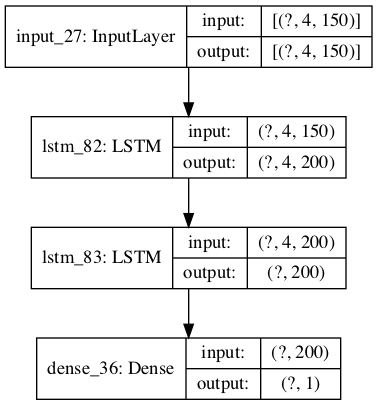

In [632]:
plot_model(lstm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Declaring the parameters of the LSTM Model

In [633]:
lstm.compile(optimizer=keras.optimizers.Adam(lr=0.01),loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.RootMeanSquaredError()])

Get data for SPX where you have Open Close and Volumen (1960)

### Fitting the LSTM Model

In [634]:
hist = lstm.fit(X_train, y_train,batch_size=700,epochs=60,verbose=1,validation_split=0.3,shuffle=False)

Epoch 1/60
6/6 [==============================] - 1s 193ms/step - loss: 0.0089 - root_mean_squared_error: 0.0945 - val_loss: 3.1353e-04 - val_root_mean_squared_error: 0.0177
Epoch 2/60
6/6 [==============================] - 1s 103ms/step - loss: 0.0011 - root_mean_squared_error: 0.0336 - val_loss: 7.7163e-04 - val_root_mean_squared_error: 0.0278
Epoch 3/60
6/6 [==============================] - 1s 105ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 4/60
6/6 [==============================] - 1s 92ms/step - loss: 7.2303e-04 - root_mean_squared_error: 0.0269 - val_loss: 1.4526e-04 - val_root_mean_squared_error: 0.0121
Epoch 5/60
6/6 [==============================] - 1s 84ms/step - loss: 2.1186e-04 - root_mean_squared_error: 0.0146 - val_loss: 7.0001e-05 - val_root_mean_squared_error: 0.0084
Epoch 6/60
6/6 [==============================] - 1s 85ms/step - loss: 1.3382e-04 - root_mean_squared_error: 0.0116 - val_loss: 

6/6 [==============================] - 1s 85ms/step - loss: 3.8515e-06 - root_mean_squared_error: 0.0020 - val_loss: 4.7232e-06 - val_root_mean_squared_error: 0.0022
Epoch 48/60
6/6 [==============================] - 1s 88ms/step - loss: 3.7894e-06 - root_mean_squared_error: 0.0019 - val_loss: 4.6308e-06 - val_root_mean_squared_error: 0.0022
Epoch 49/60
6/6 [==============================] - 1s 85ms/step - loss: 3.7271e-06 - root_mean_squared_error: 0.0019 - val_loss: 4.5384e-06 - val_root_mean_squared_error: 0.0021
Epoch 50/60
6/6 [==============================] - 1s 84ms/step - loss: 3.6649e-06 - root_mean_squared_error: 0.0019 - val_loss: 4.4461e-06 - val_root_mean_squared_error: 0.0021
Epoch 51/60
6/6 [==============================] - 1s 85ms/step - loss: 3.6026e-06 - root_mean_squared_error: 0.0019 - val_loss: 4.3541e-06 - val_root_mean_squared_error: 0.0021
Epoch 52/60
6/6 [==============================] - 1s 84ms/step - loss: 3.5403e-06 - root_mean_squared_error: 0.0019 - val

### Plotting the RSME for training and validation

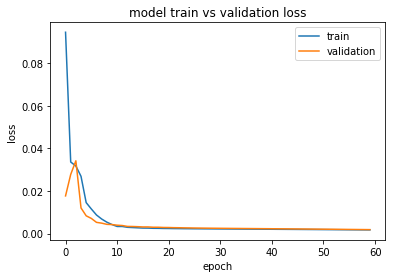

In [635]:
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Printing out the predictions made by the model

In [636]:
for ind, i in enumerate(lstm.predict(X_test)):
    
    print('Prediction: ' + str('{:.2f}'.format(round(100 * round(i[0], 4),3))) + ',    ' + 'Actual Value: ' + str('{:.2f}'.format(round(100 * round(y_test[ind][0],4),2))))

Prediction: 1.07,    Actual Value: 1.15
Prediction: 1.19,    Actual Value: 1.15
Prediction: 1.23,    Actual Value: 1.23
Prediction: 1.27,    Actual Value: 1.27
Prediction: 1.30,    Actual Value: 1.30
Prediction: 1.38,    Actual Value: 1.34
Prediction: 1.45,    Actual Value: 1.34
Prediction: 1.37,    Actual Value: 1.35
Prediction: 1.34,    Actual Value: 1.46
Prediction: 1.30,    Actual Value: 1.42
Prediction: 1.27,    Actual Value: 1.10
Prediction: 1.28,    Actual Value: 1.24
Prediction: 1.35,    Actual Value: 1.18
Prediction: 1.44,    Actual Value: 1.32
Prediction: 1.61,    Actual Value: 1.53
Prediction: 1.74,    Actual Value: 1.90
Prediction: 1.71,    Actual Value: 1.90
Prediction: 1.73,    Actual Value: 1.94
Prediction: 1.66,    Actual Value: 1.89
Prediction: 1.65,    Actual Value: 1.92
Prediction: 1.61,    Actual Value: 1.92
Prediction: 1.51,    Actual Value: 1.80
Prediction: 1.36,    Actual Value: 1.76
Prediction: 1.19,    Actual Value: 1.37
Prediction: 1.19,    Actual Value: 1.36


### Printing out the results of the model

In [637]:
def printing_out_results_of_a_model(model,X_test,y_test):
    
    y_pred = model.predict(X_test)
    
    # Print the R2 score 

    print ("R2 score:\n") 
    print (('{:.2f}'.format((100*(r2_score(y_test, y_pred))))) + " %")

    print ("\n")
    
    # Print the RMSE

    print ("RMSE:\n")
    print (math.sqrt(mean_squared_error(y_test, y_pred)))
    
    print ('\n')
    
    # Print the mean squared error
    
    print ("Mean Squared Error:\n")
    print (mean_squared_error(y_test, y_pred))

In [638]:
printing_out_results_of_a_model(lstm, X_test, y_test)

R2 score:

84.47 %


RMSE:

0.0011216986411707879


Mean Squared Error:

1.258207841604392e-06
